# Linear Regression Notebook

**Goal**: The aim of this notebook is to find out which factors affecting the housing price analysis

**Output**: Regression result and findings of which factors contribute the most to NYC housing price

**Table of Content**
- [1 Library](#1-Library)
- [2 Load Data](#2-Load-Data)
- [3 Exploratory Analysis](#3-Exploratory-Analysis)
- [4 Check Multicollinearity](#4-Check-Multicollinearity)
- [5 Regression Model](#5-Regression-Model)
    - [5.1 Benchmark-OLS](#5.1-Benchmark-OLS)
    - [5.2 OLS on Standard-Scaled Data](#5.2-OLS-on-StandardScaled-Data)
    - [5.3 OLS on LogScaled-Data](#5.3-OLS-on-LogScaled-Data)
    - [5.4 Feature Selection](#5.4-Feature-Selection)
    - [5.5 Regularization](#5.5-Regularization)
    - [5.6 Comparing Results](#5.6-Comparing-Results)
- [6 Conclusion](#6-Conclusion)

# 1 Library

In [196]:
import numpy as np
import math
import scipy.stats as scs
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, date 
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

# 2 Load Data

In [197]:
# Load the data
dataset = pd.read_csv('dataset/split/dataset_train.csv', index_col=0)
valid = pd.read_csv('dataset/split/dataset_valid.csv', index_col=0)

# Ensure that longitude and latitude are the correct data type (float)
dataset['longitude'] = dataset['longitude'].astype(float)
dataset['latitude'] = dataset['latitude'].astype(float)

# Create Point geometries
geometry = [Point(xy) for xy in zip(dataset['longitude'], dataset['latitude'])]

# Create a GeoDataFrame
propertySales = gpd.GeoDataFrame(dataset, geometry=geometry)

# Now 'gdf' is a GeoDataFrame with Point geometries
propertySales.head()

,address,zip_code,borough_name,borough,block,lot,building_class_category,category_id,building_class_name,gross_square_feet,...,subway_count_in_1km,bus_count_in_1km,schools_count_in_1km,health_facil_count_in_1km,park_properties_count_in_1km,park_zones_count_in_1km,latitude,longitude,geometry,sale_price
128157,34 GRANT AVENUE,11208,BK,3,4111,66,02 TWO FAMILY DWELLINGS,2,TWO FAMILY DWELLINGS,2088.0,...,9.0,11.0,8.0,2.0,5.0,5.0,40.690112,-73.869123,POINT (-73.86912 40.69011),925000.0
158906,131-68 233RD STREET,11422,QN,4,12943,159,01 ONE FAMILY DWELLINGS,1,ONE FAMILY DWELLINGS,1272.0,...,0.0,4.0,5.0,4.0,3.0,0.0,40.676770,-73.736272,POINT (-73.73627 40.67677),630000.0
144731,2025 EAST 74TH STREET,11234,BK,3,8415,30,02 TWO FAMILY DWELLINGS,2,TWO FAMILY DWELLINGS,1998.0,...,0.0,4.0,6.0,1.0,7.0,5.0,40.622509,-73.906276,POINT (-73.90628 40.62251),1040000.0
40959,39 GRAHAM AVENUE,11206,BK,3,3113,20,22 STORE BUILDINGS,22,STORE BUILDINGS,3875.0,...,23.0,37.0,27.0,20.0,30.0,0.0,40.702705,-73.942760,POINT (-73.94276 40.70270),2025000.0
89241,115-42 126TH STREET,11420,QN,4,11669,26,03 THREE FAMILY DWELLINGS,3,THREE FAMILY DWELLINGS,2016.0,...,0.0,7.0,5.0,1.0,7.0,0.0,40.677535,-73.813173,POINT (-73.81317 40.67754),555000.0


In [198]:
# Check dataset info
propertySales.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 86604 entries, 128157 to 143066
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   address                       86604 non-null  object  
 1   zip_code                      86604 non-null  int64   
 2   borough_name                  86604 non-null  object  
 3   borough                       86604 non-null  int64   
 4   block                         86604 non-null  int64   
 5   lot                           86604 non-null  int64   
 6   building_class_category       86604 non-null  object  
 7   category_id                   86604 non-null  int64   
 8   building_class_name           86604 non-null  object  
 9   gross_square_feet             86604 non-null  float64 
 10  year_built                    86604 non-null  float64 
 11  sale_date                     86604 non-null  object  
 12  subway_count_in_1km           86604 n

In [199]:
# Select 'housing' unit only
housing_unit_category = [1, 2, 3, 7, 8, 14]
propertySales = propertySales[propertySales['category_id'].isin(housing_unit_category)]

In [200]:
# Convert 'sale_date' to a datetime object to extract the year
propertySales['sale_date'] = pd.to_datetime(propertySales['sale_date'])

# Extract the year of sale from 'sale_date'
propertySales['sale_year'] = propertySales['sale_date'].dt.year

# Calculate age based on birth year and sale year
propertySales['age'] = propertySales['sale_year'] - propertySales['year_built']

# 3 Exploratory Analysis

In [142]:
# create function to remove outliers
def remove_outliers(set_data):
    num_col = set_data.select_dtypes(include=['int64', 'float64']).columns.to_list()
    
    list_of_set_data = list()

    for col_name in num_col:
        q1 = set_data[col_name].quantile(0.1)
        q3 = set_data[col_name].quantile(0.9)
        iqr = q3 - q1
        set_data = set_data[~((set_data[col_name] < (q1 - 1.5 * iqr))
                            | (set_data[col_name] > (q3 + 1.5 * iqr)))].copy()

    return set_data

In [143]:
# Remove outliers
print(len(propertySales))
# propertySales = remove_outliers(propertySales)
#valid_set = remove_outliers(valid_set)
#test_set = remove_outliers(test_set)

print(len(propertySales))
#print(len(valid_set))
#print(len(test_set))

82201
82201


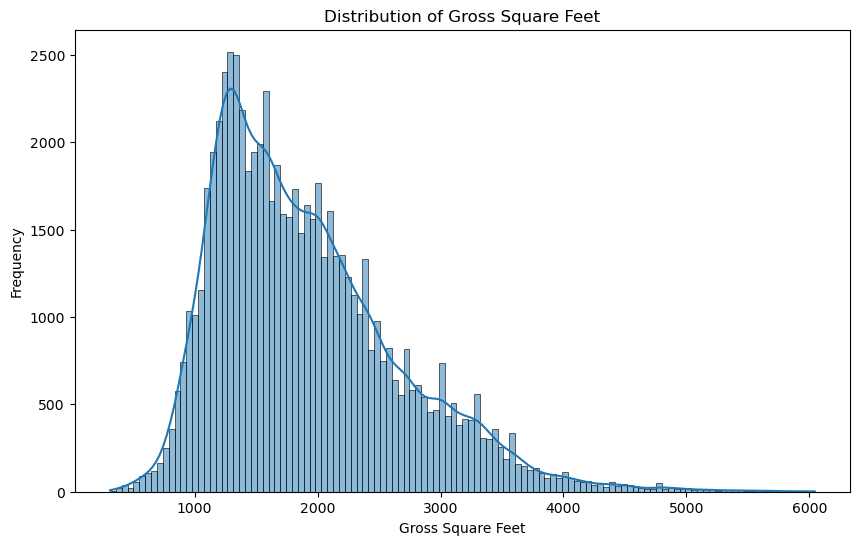

In [144]:
# Univariate Analysis for 'gross_square_feet'
plt.figure(figsize=(10, 6))
sns.histplot(propertySalesFiltered['gross_square_feet'].dropna(), kde=True)
plt.title('Distribution of Gross Square Feet')
plt.xlabel('Gross Square Feet')
plt.ylabel('Frequency')
plt.show()

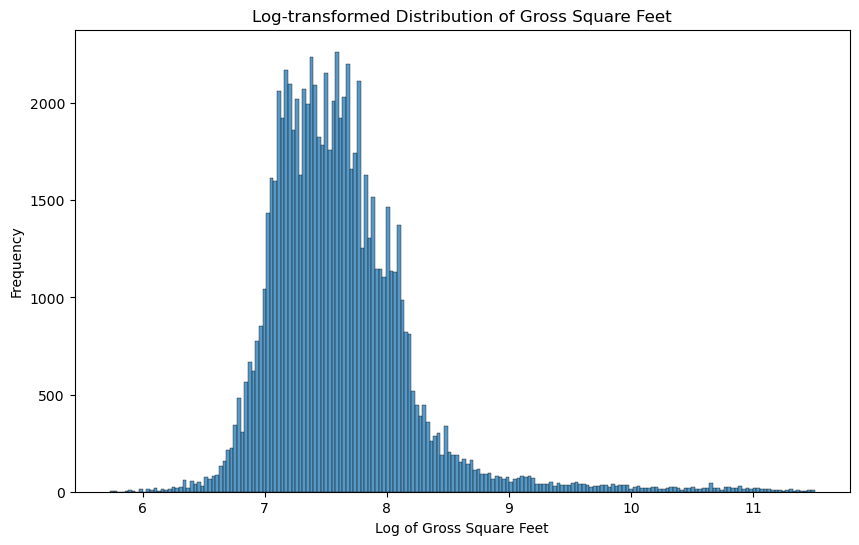

In [145]:
# Log Transformation of 'gross_square_feet'
propertySales['log_gross_square_feet'] = np.log1p(propertySales['gross_square_feet'])

# Plot the distribution after log transformation
plt.figure(figsize=(10, 6))
sns.histplot(propertySales['log_gross_square_feet'].dropna())
plt.title('Log-transformed Distribution of Gross Square Feet')
plt.xlabel('Log of Gross Square Feet')
plt.ylabel('Frequency')
plt.show()

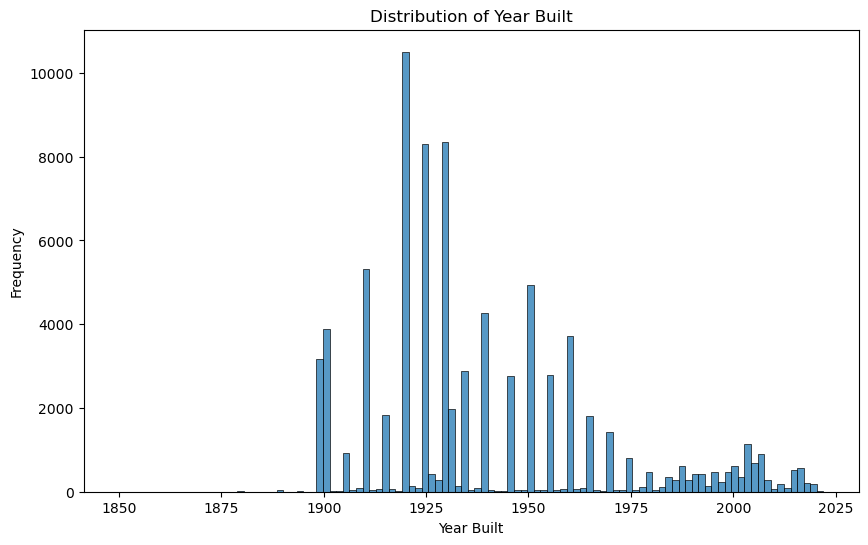

In [146]:
# Univariate Analysis for 'year_built'
plt.figure(figsize=(10, 6))
sns.histplot(propertySales['year_built'].dropna(), kde=False)
plt.title('Distribution of Year Built')
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.show()


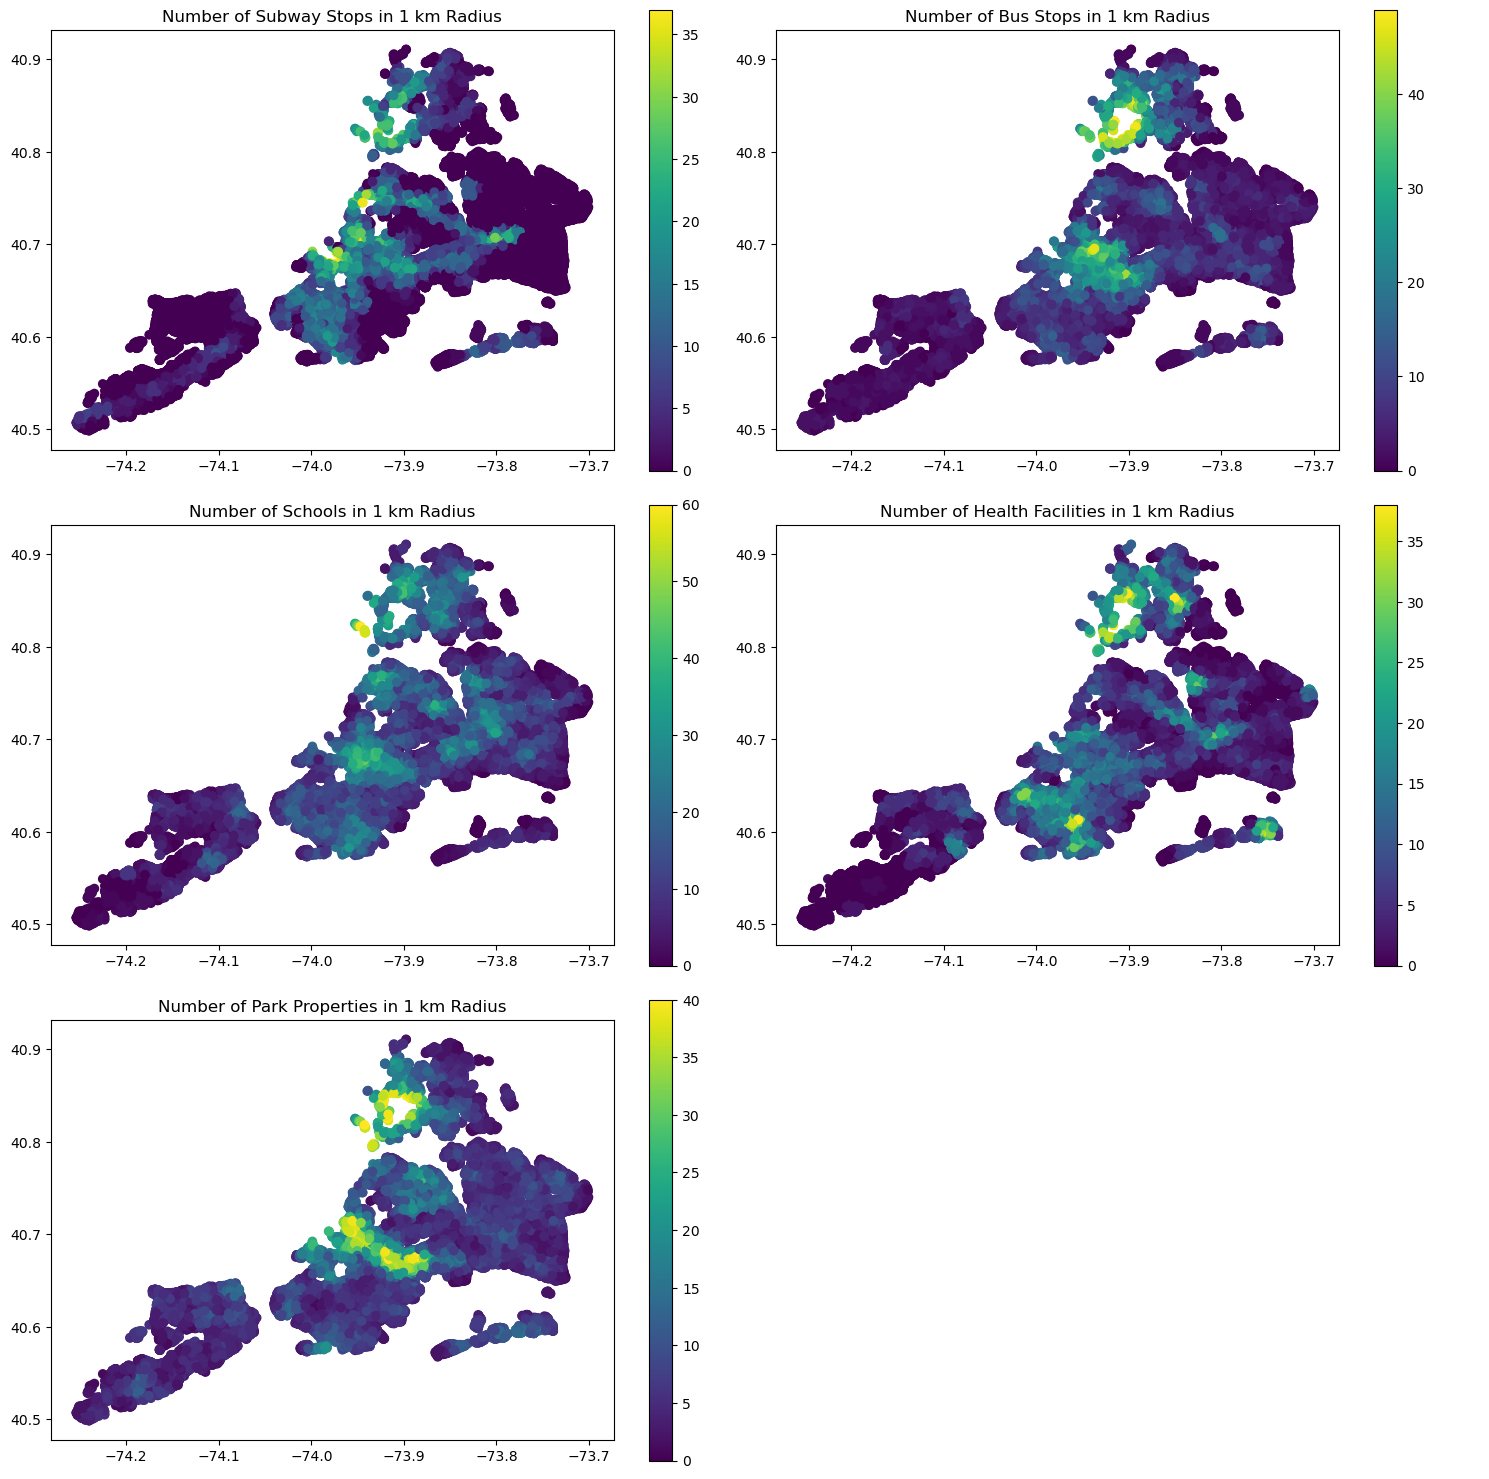

In [49]:
# Plotting nearby infrastructure data
## Create a subplot grid with 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

## Plotting 'subway_count_in_1km'
propertySales.plot(column='subway_count_in_1km', ax=axs[0, 0], legend=True)
axs[0, 0].set_title('Number of Subway Stops in 1 km Radius')

## Plotting 'bus_count_in_1km'
propertySales.plot(column='bus_count_in_1km', ax=axs[0, 1], legend=True)
axs[0, 1].set_title('Number of Bus Stops in 1 km Radius')

## Plotting 'schools_count_in_1km'
propertySales.plot(column='schools_count_in_1km', ax=axs[1, 0], legend=True)
axs[1, 0].set_title('Number of Schools in 1 km Radius')

## Plotting 'health_facil_count_in_1km'
propertySales.plot(column='health_facil_count_in_1km', ax=axs[1, 1], legend=True)
axs[1, 1].set_title('Number of Health Facilities in 1 km Radius')

## Plotting 'park_properties_count_in_1km'
propertySales.plot(column='park_properties_count_in_1km', ax=axs[2, 0], legend=True)
axs[2, 0].set_title('Number of Park Properties in 1 km Radius')

## Hide the empty subplot
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()

# 4 Multicolinearity Check

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for each feature
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

# Ensure all columns used for VIF calculation are numeric and contain no infinity or missing values
numeric_df = propertySales[predictors].select_dtypes(include=[np.number]).dropna().replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Calculate VIF for each independent variable
calc_vif(numeric_df)

,variables,VIF
0,gross_square_feet,1.445170
1,year_built,3.398204
2,subway_count_in_1km,2.442265
3,bus_count_in_1km,6.202137
4,schools_count_in_1km,5.938302
5,health_facil_count_in_1km,3.711093
6,park_properties_count_in_1km,5.438658
7,park_zones_count_in_1km,1.750442


**Variance Inflation Factors (VIF)**

- VIF > 10: Indicates the possibility of multicollinearity
- VIF > 100: There is definitely multicollinearity among the variables

In this data, there is no indication of multicollinearity

# 5 Regression Model

In [147]:
# Define predictors
predictors =  [
    'building_class_category', 'gross_square_feet', 'year_built', 
    'subway_count_in_1km', 'bus_count_in_1km', 
    'schools_count_in_1km', 'health_facil_count_in_1km',
    'park_properties_count_in_1km', 'park_zones_count_in_1km'
]

## 5.1 Benchmark OLS

In [148]:
# Modeling
formula = 'sale_price ~ ' + ' + '.join(predictors)
lm = smf.ols(formula=formula, data=propertySales).fit()
OLS_coef = lm.params
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     4351.
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:38:21   Log-Likelihood:            -1.3183e+06
No. Observations:               82201   AIC:                         2.637e+06
Df Residuals:                   82187   BIC:                         2.637e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

**Interpretation**

1. Model Fit:
- R-squared: 0.408 - This indicates that approximately 40.8% of the variability in sale prices can be explained by the model's independent variables.
- Adj. R-squared: 0.408 - Adjusted for the number of predictors, the proportion of variance explained remains the same, which suggests the model isn’t penalized much for any unnecessary variables.

2. Coefficients:
- Intercept: The model predicts a baseline sale price (when all other variables are 0) which is negative, suggesting that without the presence of these building characteristics, the model does not predict a viable sale price. This could be due to scaling or the nature of the variables.
- Building Class: Relative to the baseline category (presumably '01 ONE FAMILY DWELLINGS'), two-family dwellings (T2) and three-family dwellings (T3) are associated with a decrease in sale price, while elevator apartments (T8) and 4-10 unit rentals (T4) are associated with an increase in sale price.
- Gross Square Feet: This has a positive coefficient, meaning that as the gross square footage of a property increases, so does its sale price.
- Year Built: The coefficient is positive, but not statistically significant (p > 0.05), suggesting that the year a building was constructed does not have a significant effect on the sale price within this model.
- Proximity Variables: The number of subway, schools, and parks within a 1km radius is positively associated with the sale price, while the number of bus stops and health facilities is negatively associated. 

3. Statistical Significance:
- P>|t|: Values below 0.05 indicate that we can reject the null hypothesis that the coefficient is zero (no effect). In this model, `year_built` (0.436) is the only regressor that is not statistically significant, among others.

4. Diagnostics:
- Durbin-Watson: Close to 2, suggesting there is no significant autocorrelation in the residuals.
- Omnibus/Prob(Omnibus): Indicates the residuals are not normally distributed, which could affect the validity of the confidence intervals and hypothesis tests.
- Skew: Positive value indicates a right-skewed distribution of residuals.
- Kurtosis: The large kurtosis value suggests that the tails are heavy, and there are outliers affecting the distribution of residuals.

In [149]:
# Make predictions using trained model
y_true = propertySales['sale_price']
y_pred = lm.predict(propertySales[predictors])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 657249.7284737974
Mean Absolute Percentage Error (MAPE): 136.70072359141056%
Mean Squared Error (MSE): 4985635696793.192
Root Mean Squared Error (RMSE): 2232853.711462798


## 5.2 OLS on StandardScaled Data

In [150]:
# Select the numerical columns you want to scale
numerical_var = ['gross_square_feet', 'year_built', 'subway_count_in_1km', 'bus_count_in_1km', 
                 'schools_count_in_1km', 'health_facil_count_in_1km', 
                 'park_properties_count_in_1km', 'park_zones_count_in_1km']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numerical columns
propertySalesScaled = propertySales.copy()
propertySalesScaled[numerical_var] = scaler.fit_transform(propertySales[numerical_var])
propertySalesScaled.head()

,address,zip_code,borough_name,borough,block,lot,building_class_category,category_id,building_class_name,gross_square_feet,...,health_facil_count_in_1km,park_properties_count_in_1km,park_zones_count_in_1km,latitude,longitude,geometry,sale_price,sale_year,age,log_gross_square_feet
128157,34 GRANT AVENUE,11208,BK,3,4111,66,02 TWO FAMILY DWELLINGS,2,TWO FAMILY DWELLINGS,-0.129707,...,-0.777153,-0.539631,0.37016,40.690112,-73.869123,POINT (-73.86912 40.69011),925000.0,2020,121.0,7.644441
158906,131-68 233RD STREET,11422,QN,4,12943,159,01 ONE FAMILY DWELLINGS,1,ONE FAMILY DWELLINGS,-0.290651,...,-0.521941,-0.754137,-0.74854,40.676770,-73.736272,POINT (-73.73627 40.67677),630000.0,2021,71.0,7.149132
144731,2025 EAST 74TH STREET,11234,BK,3,8415,30,02 TWO FAMILY DWELLINGS,2,TWO FAMILY DWELLINGS,-0.147458,...,-0.904759,-0.325125,0.37016,40.622509,-73.906276,POINT (-73.90628 40.62251),1040000.0,2021,56.0,7.600402
89241,115-42 126TH STREET,11420,QN,4,11669,26,03 THREE FAMILY DWELLINGS,3,THREE FAMILY DWELLINGS,-0.143908,...,-0.904759,-0.325125,-0.74854,40.677535,-73.813173,POINT (-73.81317 40.67754),555000.0,2018,29.0,7.609367
48772,90-12 SUTTER AVE,11417,QN,4,11353,6,02 TWO FAMILY DWELLINGS,2,TWO FAMILY DWELLINGS,-0.080596,...,-0.266729,0.425646,-0.52480,40.676245,-73.846405,POINT (-73.84641 40.67624),120000.0,2017,42.0,7.757051


In [151]:
# Fit
formula_scaled = 'sale_price ~ ' + ' + '.join(predictors)
lm_scaled = smf.ols(formula=formula_scaled, data=propertySalesScaled).fit()
OLS_coef_scaled = lm_scaled.params
print(lm_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     4351.
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:38:22   Log-Likelihood:            -1.3183e+06
No. Observations:               82201   AIC:                         2.637e+06
Df Residuals:                   82187   BIC:                         2.637e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [152]:
# Make predictions using trained model
y_true = propertySalesScaled['sale_price']
y_pred_scaled = lm_scaled.predict(propertySalesScaled[predictors])

# Calculate Mean Absolute Error (MAE)
mae_scaled = mean_absolute_error(y_true, y_pred_scaled)
print(f"Mean Absolute Error (MAE): {mae_scaled}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape_scaled = np.mean(np.abs((y_true - y_pred_scaled) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_scaled}%")

# Calculate Mean Squared Error (MSE)
mse_scaled = mean_squared_error(y_true, y_pred_scaled)
print(f"Mean Squared Error (MSE): {mse_scaled}")

# Calculate Root Mean Squared Error (RMSE)
rmse_scaled = np.sqrt(mse_scaled)
print(f"Root Mean Squared Error (RMSE): {rmse_scaled}")

Mean Absolute Error (MAE): 657249.7284737907
Mean Absolute Percentage Error (MAPE): 136.70072359141366%
Mean Squared Error (MSE): 4985635696793.192
Root Mean Squared Error (RMSE): 2232853.711462798


## 5.3 OLS on LogScaled Data

In [129]:
# Log-scale the selected regressor variables
propertySales_log = propertySales.copy()  

# Log-scale the selected columns (adding a small constant to avoid log(0))
propertySales_log[numerical_var] = np.log1p(propertySales_log[numerical_var])

# Rename the log-scaled columns with a "_log" suffix
propertySales_log.columns = [col + "_log" if col in numerical_var else col for col in propertySales_log.columns]

# Merge the log-scaled DataFrame with your main DataFrame using the common identifier
propertySales_log

,address,zip_code,borough_name,borough,block,lot,building_class_category,category_id,building_class_name,gross_square_feet_log,...,health_facil_count_in_1km_log,park_properties_count_in_1km_log,park_zones_count_in_1km_log,latitude,longitude,geometry,sale_price,log_gross_square_feet,sale_year,age
128157,34 GRANT AVENUE,11208,BK,3,4111,66,02 TWO FAMILY DWELLINGS,2,TWO FAMILY DWELLINGS,7.644441,...,1.098612,1.791759,1.791759,40.690112,-73.869123,POINT (-73.86912 40.69011),925000.0,7.644441,2020,121.0
158906,131-68 233RD STREET,11422,QN,4,12943,159,01 ONE FAMILY DWELLINGS,1,ONE FAMILY DWELLINGS,7.149132,...,1.609438,1.386294,0.000000,40.676770,-73.736272,POINT (-73.73627 40.67677),630000.0,7.149132,2021,71.0
144731,2025 EAST 74TH STREET,11234,BK,3,8415,30,02 TWO FAMILY DWELLINGS,2,TWO FAMILY DWELLINGS,7.600402,...,0.693147,2.079442,1.791759,40.622509,-73.906276,POINT (-73.90628 40.62251),1040000.0,7.600402,2021,56.0
89241,115-42 126TH STREET,11420,QN,4,11669,26,03 THREE FAMILY DWELLINGS,3,THREE FAMILY DWELLINGS,7.609367,...,0.693147,2.079442,0.000000,40.677535,-73.813173,POINT (-73.81317 40.67754),555000.0,7.609367,2018,29.0
48772,90-12 SUTTER AVE,11417,QN,4,11353,6,02 TWO FAMILY DWELLINGS,2,TWO FAMILY DWELLINGS,7.757051,...,1.945910,2.708050,0.693147,40.676245,-73.846405,POINT (-73.84641 40.67624),120000.0,7.757051,2017,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6525,606 HENRY STREET,11231,BK,3,364,30,07 RENTALS - WALKUP APARTMENTS,7,RENTALS - WALKUP APARTMENTS,8.158516,...,2.079442,2.995732,2.079442,40.680352,-74.001503,POINT (-74.00150 40.68035),3860000.0,8.158516,2016,86.0
94820,228 BAYVIEW AVENUE,10309,SI,5,6742,25,01 ONE FAMILY DWELLINGS,1,ONE FAMILY DWELLINGS,6.797940,...,1.098612,1.098612,1.098612,40.519530,-74.205024,POINT (-74.20502 40.51953),550000.0,6.797940,2018,117.0
183653,215-34 MURDOCK AVENUE,11429,QN,4,11232,22,01 ONE FAMILY DWELLINGS,1,ONE FAMILY DWELLINGS,7.431892,...,1.098612,1.609438,0.000000,40.703118,-73.739172,POINT (-73.73917 40.70312),640000.0,7.431892,2022,87.0
113299,130-33 226TH STREET,11413,QN,4,12904,20,01 ONE FAMILY DWELLINGS,1,ONE FAMILY DWELLINGS,7.284135,...,1.098612,1.386294,0.000000,40.681768,-73.741116,POINT (-73.74112 40.68177),450000.0,7.284135,2019,89.0


In [156]:
# Determine predictors
log_predictors = ['building_class_category', 'gross_square_feet_log', 'year_built_log',
               'subway_count_in_1km_log', 'bus_count_in_1km_log',
               'schools_count_in_1km_log', 'health_facil_count_in_1km_log',
               'park_properties_count_in_1km_log', 'park_zones_count_in_1km_log']

In [157]:
# Modeling
formula_log_scaled = 'sale_price ~ ' + ' + '.join(log_predictors)
lm_log_scaled = smf.ols(formula=formula_log_scaled, data=propertySales_log).fit()
OLS_coef_log_scaled = lm_log_scaled.params
print(lm_log_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     3261.
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:42:30   Log-Likelihood:            -1.3227e+06
No. Observations:               82201   AIC:                         2.646e+06
Df Residuals:                   82187   BIC:                         2.646e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [159]:
# Make predictions using trained model
y_true = propertySales_log['sale_price']
y_pred_log_scaled = lm_log_scaled.predict(propertySales_log[log_predictors])

# Calculate Mean Absolute Error (MAE)
mae_log_scaled = mean_absolute_error(y_true, y_pred_log_scaled)
print(f"Mean Absolute Error (MAE): {mae_log_scaled}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape_log_scaled = np.mean(np.abs((y_true - y_pred_log_scaled) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_log_scaled}%")

# Calculate Mean Squared Error (MSE)
mse_log_scaled = mean_squared_error(y_true, y_pred_log_scaled)
print(f"Mean Squared Error (MSE): {mse_log_scaled}")

# Calculate Root Mean Squared Error (RMSE)
rmse_log_scaled = np.sqrt(mse_log_scaled)
print(f"Root Mean Squared Error (RMSE): {rmse_log_scaled}")

Mean Absolute Error (MAE): 776457.0958513416
Mean Absolute Percentage Error (MAPE): 160.45648773144114%
Mean Squared Error (MSE): 5552706195755.287
Root Mean Squared Error (RMSE): 2356418.0859421543


## 5.4 Feature Selection

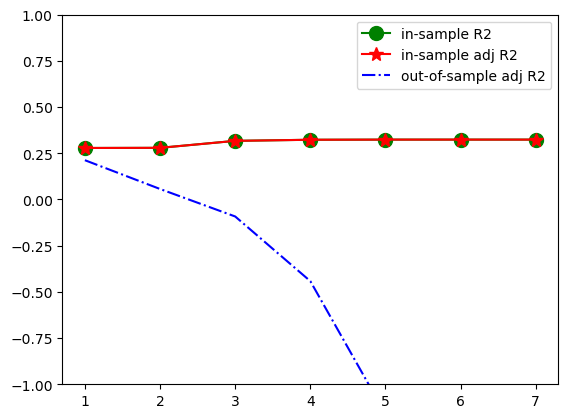

Best Feature Set(s) with Maximum Adjusted R2: ['gross_square_feet', 'year_built', 'subway_count_in_1km', 'bus_count_in_1km', 'schools_count_in_1km', 'health_facil_count_in_1km']
Best Adjusted R2: 0.3825404117298674


In [194]:
# Define predictors
predictors = ['gross_square_feet', 'year_built', 'subway_count_in_1km', 
              'bus_count_in_1km', 'schools_count_in_1km', 'health_facil_count_in_1km', 
              'park_properties_count_in_1km', 'park_zones_count_in_1km']

# Prepare data and Number of predictors
train = propertySales.copy()
n = len(predictors) 

# The auxiliary function implementing regression based on the selected subset of features
def AdjR2(flag):
    '''
    Evaluate the model with adjusted R-squared,
    with flag indicating the feature selection
    1--feature included
    0--feature excluded
    '''
    formstr='sale_price ~ '
    included_predictors = [predictors[i] for i in range(n) if flag[i] == 1]
    formstr += ' + '.join(included_predictors)
    
    lm = smf.ols(formula=formstr, data=train).fit()
    lmy = lm.predict(valid)
    y_err = lmy - valid['sale_price']
    y_norm = valid['sale_price'] - valid['sale_price'].mean()
    # Adjusted R^2
    R2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm)
    adjR2_OS = 1 - y_err.dot(y_err) / y_norm.dot(y_norm) * (n-1) / (n-sum(flag)-1)
    return lm, R2_OS, adjR2_OS

# Implement the regression with out-of-sample evaluation for different numbers of features included
adjR2 = []
regR2 = []
OSR2 = []
best_adjR2 = -1  # Initialize best adjusted R2 value
best_feature_set = []  # Initialize the best feature set

for i in range(1, n):
    lm, R2_OS, adjR2_OS = AdjR2([1]*i + [0]*(n-i))
    regR2.append(lm.rsquared)
    adjR2.append(lm.rsquared_adj)
    OSR2.append(adjR2_OS)
    
    # Check if the current feature set has a better adjusted R2
    if R2_OS > best_adjR2:
        best_adjR2 = R2_OS
        best_feature_set = [predictors[j] for j in range(n) if ([1]*i + [0]*(n-i))[j] == 1]
    elif R2_OS == best_adjR2:
        # If multiple feature sets have the same best adjusted R2, add them to the list
        best_feature_set += [predictors[j] for j in range(n) if ([1]*i + [0]*(n-i))[j] == 1]

# In-sample R2
plt.plot(range(1, n), regR2, 'g-o', markersize=10)
plt.plot(range(1, n), adjR2, 'r-*', markersize=10)
plt.plot(range(1, n), OSR2, 'b-.', markersize=10)
plt.ylim((-1, 1))
plt.legend(('in-sample R2', 'in-sample adj R2', 'out-of-sample adj R2'))
plt.show()

print("Best Feature Set(s) with Maximum Adjusted R2:", best_feature_set)
print("Best Adjusted R2:", best_adjR2)


In [206]:
# Define predictors
predictors_selected =  [
    'building_class_category', 'gross_square_feet', 'year_built', 
    'subway_count_in_1km', 'bus_count_in_1km', 
    'schools_count_in_1km', 'health_facil_count_in_1km',
]

# Modeling
formula_selected = 'sale_price ~ ' + ' + '.join(predictors_selected)
lm_selected = smf.ols(formula=formula_selected, data=propertySales).fit()
OLS_coef = lm_selected.params
print(lm_selected.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     4990.
Date:                Fri, 19 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:21:34   Log-Likelihood:            -1.3188e+06
No. Observations:               82201   AIC:                         2.638e+06
Df Residuals:                   82189   BIC:                         2.638e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [209]:
# Make predictions using trained model
y_true = propertySales_log['sale_price']
y_pred_selected = lm_selected.predict(propertySales[predictors_selected])

# Calculate Mean Absolute Error (MAE)
mae_selected = mean_absolute_error(y_true, y_pred_selected)
print(f"Mean Absolute Error (MAE): {mae_selected}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape_selected = np.mean(np.abs((y_true - y_pred_selected) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_selected}%")

# Calculate Mean Squared Error (MSE)
mse_selected = mean_squared_error(y_true, y_pred_selected)
print(f"Mean Squared Error (MSE): {mse_selected}")

# Calculate Root Mean Squared Error (RMSE)
rmse_selected = np.sqrt(mse_selected)
print(f"Root Mean Squared Error (RMSE): {rmse_selected}")

Mean Absolute Error (MAE): 650473.4064862224
Mean Absolute Percentage Error (MAPE): 134.8425202051855%
Mean Squared Error (MSE): 5046778912946.042
Root Mean Squared Error (RMSE): 2246503.708642842


## 5.5 Regularization

**Ridge**

In [213]:
# Create the feature matrix X and the target vector y
X = propertySales[predictors]
y = propertySales['sale_price']

# #Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# #Splitting datas
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#Initialize the Ridge regression model with an arbitrary alpha value
ridge_model = Ridge(alpha=1.0)

#Fit the Ridge model to the training data
ridge_model.fit(X, y)

Ridge()

In [214]:
# Make predictions using trained model
y_true = propertySales_log['sale_price']
y_pred_ridge = ridge_model.predict(propertySales[predictors])

# Calculate Mean Absolute Error (MAE)
mae_ridge = mean_absolute_error(y_true, y_pred_ridge)
print(f"Mean Absolute Error (MAE): {mae_ridge}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape_ridge = np.mean(np.abs((y_true - y_pred_ridge) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_ridge}%")

# Calculate Mean Squared Error (MSE)
mse_ridge = mean_squared_error(y_true, y_pred_ridge)
print(f"Mean Squared Error (MSE): {mse_ridge}")

# Calculate Root Mean Squared Error (RMSE)
rmse_ridge = np.sqrt(mse_ridge)
print(f"Root Mean Squared Error (RMSE): {rmse_ridge}")

Mean Absolute Error (MAE): 665485.459255033
Mean Absolute Percentage Error (MAPE): 138.147600084906%
Mean Squared Error (MSE): 5023296944116.272
Root Mean Squared Error (RMSE): 2241271.2785640815


**Lasso**

In [216]:
# Create the LassoCV object, which will perform cross-validation
lasso_cv = LassoCV(cv=5, random_state=0)

# Fit the model to the training data
lasso_cv.fit(X, y) 

LassoCV(cv=5, random_state=0)

In [218]:
# Make predictions using trained model
y_true = propertySales_log['sale_price']
y_pred_lasso = lasso_cv.predict(propertySales[predictors])

# Calculate Mean Absolute Error (MAE)
mae_lasso = mean_absolute_error(y_true, y_pred_lasso)
print(f"Mean Absolute Error (MAE): {mae_lasso}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape_lasso = np.mean(np.abs((y_true - y_pred_lasso) / y_true)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape_lasso}%")

# Calculate Mean Squared Error (MSE)
mse_lasso = mean_squared_error(y_true, y_pred_lasso)
print(f"Mean Squared Error (MSE): {mse_lasso}")

# Calculate Root Mean Squared Error (RMSE)
rmse_lasso = np.sqrt(mse_lasso)
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")

Mean Absolute Error (MAE): 644715.0768479859
Mean Absolute Percentage Error (MAPE): 130.75000308115318%
Mean Squared Error (MSE): 5577787152776.903
Root Mean Squared Error (RMSE): 2361733.929293667


# 5.6 Comparing Results

In [219]:
# Create a dictionary to store the results
results_dict = {
    'Method': ['Benchmark', 'Standard Scaled Features', 'Log Scaled Features', 'Selected Features', 'Ridge', 'Lasso'],
    'MAE': [mae, mae_scaled, mae_log_scaled, mae_selected, mae_ridge, mae_lasso],
    'MAPE (%)': [mape, mape_scaled, mape_log_scaled, mape_selected, mape_ridge, mape_lasso],
    'MSE': [mse, mse_scaled, mse_log_scaled, mse_selected, mse_ridge, mse_lasso],
    'RMSE': [rmse, rmse_scaled, rmse_log_scaled, rmse_selected, rmse_ridge, rmse_lasso]
}

# Create a dataframe from the results dictionary
results_df = pd.DataFrame(results_dict)

# Print the combined results dataframe
results_df

,Method,MAE,MAPE (%),MSE,RMSE
0,Benchmark,657249.728474,136.700724,4.985636e+12,2.232854e+06
1,Standard Scaled Features,657249.728474,136.700724,4.985636e+12,2.232854e+06
2,Log Scaled Features,776457.095851,160.456488,5.552706e+12,2.356418e+06
3,Selected Features,650473.406486,134.842520,5.046779e+12,2.246504e+06
4,Ridge,665485.459255,138.147600,5.023297e+12,2.241271e+06
5,Lasso,644715.076848,130.750003,5.577787e+12,2.361734e+06


# 6 Conclusion

Based on four evaluation metrics, the linear regression model appears to underperform. The high MAPE (greater than 100%) is often a sign that the model may not be suitable for the dataset or that the data requires transformation or cleaning before modeling. Therefore, machine learning models will be explored in the subsequent notebook.